 ## Importing relevant libraries 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, make_scorer, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

## Functions

In [2]:
def score_recorder(classifier_name, ml_model, X_train, y_train, X_test, y_test):
    """
    A function to record the precision and recall score for different
    classifier trials to comapre the performance. 
    Classifier_name : a string name of the classifier used for study.
    ml_model : The ML model trained for classification problem. 
    X_train : The train data.
    y_train : The train labels
    X_test : The test data.
    y_test : The test labels
    """
    y_pred_test = ml_model.predict(X_test) 
    
    scores = {
        'Train_accuracy' : ml_model.score(X_train, y_train),
        'Test_accuracy' : ml_model.score(X_test, y_test),
        'Balanced_accuracy' : balanced_accuracy_score(y_test, y_pred_test),
        'Test_Precision' : precision_score(y_test, y_pred_test, pos_label = "ready"),
        'Test_Recall' : recall_score(y_test, y_pred_test, pos_label="ready"),
        'Test_F1_score' : f1_score(y_test, y_pred_test, pos_label = "ready" )
    }
    
    df_scores = pd.DataFrame(scores, index = [classifier_name])
    
    return df_scores

In [3]:
# for reproducibility of the models. 
random_state = 0

## Data preprocessing and labelling. 

> * The dataset was heavly imbalanced that is only 1 sample for LT ready. 
> * By plotting the differences between heating demand and cold horus in HT and LT , it was noticed that the cold hours difference between LT and HT zero is strict. 
> * That means if a house has 100 cold hours in HT and 99 cold hours in LT then it is `ready` whereas if another sample has 101 then it is `not LT ready`. 
> * Therefore, by visual inspection 15 hour (one occupied day in the living room) was taken as threshold for labelling samples as `ready` or `not ready`. 
>> * If the absolute difference between cold hours in LT and HT supply is more than 12 then it is labeled as `not ready`. Otherwise `ready`. 

In [5]:
# Load the data from excel
HT_df = pd.read_excel("2024-04-23_outputfile_itr_1_size_1300_HT.xlsx")
LT_df = pd.read_excel("2024-04-23_outputfile_itr_1_size_1300_LT.xlsx")

# sample number as column index 
HT_df.set_index('Sample Number', inplace = True)
LT_df.set_index('Sample Number', inplace = True)

# Define your threshold
threshold_cold_hours = 15 # adjust as needed
threshold_shd = 0

# Loop through each sample
for sample in HT_df.index:
    # Get heating demand and cold hours for each sample in HT supply
    HT_heating_demand = HT_df.loc[sample, 'Heating_demand']
    HT_cold_hours = HT_df.loc[sample, 'Underheated_hours']
    
    # Get heating demand and cold hours for each sample in MT supply
    LT_heating_demand = LT_df.loc[sample, 'Heating_demand']
    LT_cold_hours = LT_df.loc[sample, 'Underheated_hours']
    
    # Check for LTH readiness
    # if heating demands or cold hours in MT supply are higher than those in HT supply
    # then sample is "not ready: 0" for MT
    if abs(HT_heating_demand - LT_heating_demand) < threshold_shd or abs(LT_cold_hours-HT_cold_hours) > threshold_cold_hours:
        LT_df.loc[sample, 'label'] = "not_ready" # Not ready
        
    # if not then the sample is "ready" for LT
    else:
        LT_df.loc[sample, 'label'] = "ready" # ready

## Setting features and target

In [6]:
# Access the features
LT_df.columns

Index(['Construction Year', 'orientation', 'compactness_ratio', 'WWR', 'Rc_Gr',
       'Rc_Wl', 'Rc_Rf', 'U_Gz', 'U_Dr', 'Inf', 'Vent_sys', 'Temp_set',
       'Heating_demand', 'Underheated_hours', 'label'],
      dtype='object')

> * We will drop `Construction Year` because it is an identifier of the sample and for only reference puporses.
> * `Heating_demand` and `Underheated_hours` will also be dropped because they are the simulation outputs. We can use these outputs to develop a regression ML model.
> * However, we want to understand the combined effect of heating demand and thermal comfort on making a sample `ready` or `not ready` using the `Lower Temperature Heating Ready` definition developed in this research. 
>>Therefore, `label` column is our <b> target </b> and
>>`orientation, compactness ratio, WWR, Insulation (wall, floor, roof, windows, door), infilteration , ventilation system` and `heating setpoint` are the <b> features </b> for our classification problem. 

In [7]:
data = LT_df.drop(columns=['Construction Year', 'label', 'Heating_demand', 'Underheated_hours'])
target = LT_df['label']

data

,orientation,compactness_ratio,WWR,Rc_Gr,Rc_Wl,Rc_Rf,U_Gz,U_Dr,Inf,Vent_sys,Temp_set
Sample Number,,,,,,,,,,,
1,90,1.015354,29,3.516031,2.214790,3.505104,2.463229,3.037537,1.115838,3,21
2,0,1.858442,31,1.451131,0.369810,1.620055,2.682916,3.042459,1.921535,1,20
3,180,1.630032,29,4.106602,3.684955,2.305246,2.680176,3.223157,0.897848,3,21
4,0,1.411543,31,2.298882,1.963910,3.219770,2.896433,2.655416,1.619801,1,19
5,90,1.339837,36,0.791084,1.921325,1.279116,3.875913,3.164528,2.965559,3,18
...,...,...,...,...,...,...,...,...,...,...,...
1296,90,1.395122,29,2.105027,2.228963,6.765320,1.851061,2.374605,1.066517,7,20
1297,135,1.314427,36,2.942374,2.410997,1.652692,3.888668,3.169178,2.284567,1,21
1298,135,1.901989,36,2.647939,2.506032,0.917718,3.735175,2.890603,2.091183,1,21


> * Random Forest Classifier can handel the data without scaling and encoding. so the data was used as such. 

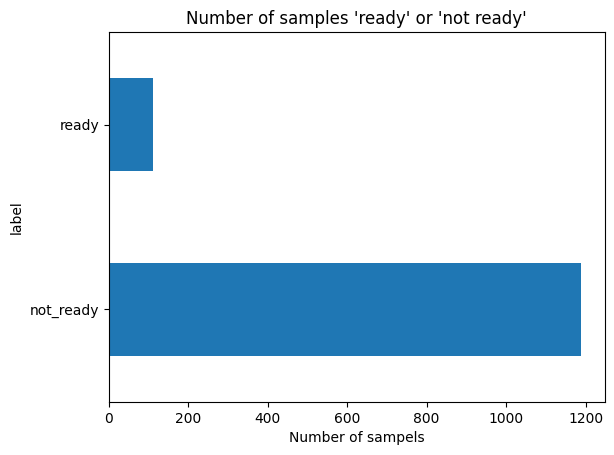

In [8]:
# Visualise the distribution of the target

target.value_counts().plot.barh()
plt.xlabel("Number of sampels")
_ = plt.title("Number of samples 'ready' or 'not ready'")

In [9]:
target.value_counts()

label
not_ready    1189
ready         111
Name: count, dtype: int64

In [10]:
target.value_counts(normalize=True)*100

label
not_ready    91.461538
ready         8.538462
Name: proportion, dtype: float64

> * As it can be observed that the we have imbalanced sample. Therefore, the trained model will be biased towards classifying a sample to be `"not ready"`. 

## Train-Test split

In [11]:
data_train, data_test, target_train, target_test = train_test_split(
    data, 
    target, 
    shuffle=True, 
    random_state=random_state, 
    test_size=0.2
)

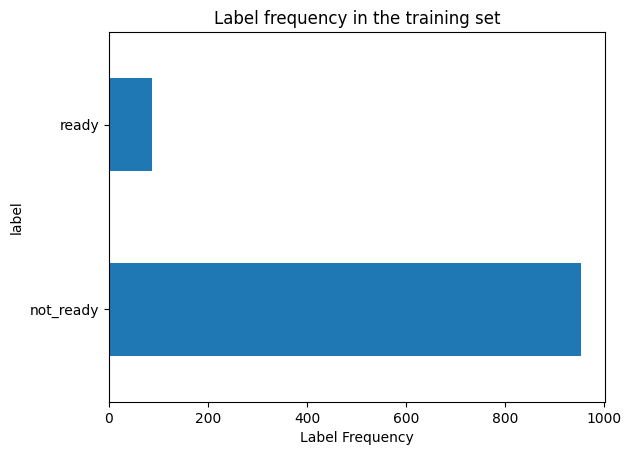

In [12]:
target_train.value_counts().plot.barh()
plt.xlabel("Label Frequency")
_ = plt.title("Label frequency in the training set")

In [13]:
target_train.value_counts()

label
not_ready    953
ready         87
Name: count, dtype: int64

In [14]:
target_train.value_counts(normalize=True)*100

label
not_ready    91.634615
ready         8.365385
Name: proportion, dtype: float64

> * This also demonstrates that the training set made from our dataset is imbalanced with around <b>8%</b> `'1: ready'` and <b>91%</b> `'0: not ready'`.
>* The imbalanced dataset will affect the generalisation ability of the model as the dataset is biased towards predicting a sample being `not ready`. 

## Prepare baseline performance. 

>During class imbalance the accuracy of the Random forest(RF) classifier is linked to its ability to correctly predict the negative class `'not ready'`. We can illustrate the issue using a dummy classifier as a baseline.

##### Dummy classifier

In [15]:
dummy_classifier = DummyClassifier(strategy="most_frequent")

dummy_classifier.fit(data_train, target_train)

accuracy_dummy = dummy_classifier.score(data_test, target_test)

print(f"The accuracy of the dummy classifier: {accuracy_dummy}")

The accuracy of the dummy classifier: 0.9076923076923077


##### Random Forest Classifier

In [16]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=random_state)

rf.fit(data_train, target_train)

accuracy_rf = rf.score(data_test, target_test)

print(f"The accuracy of the rf classifier: {accuracy_rf}")

The accuracy of the rf classifier: 0.9653846153846154


> * It is observed, the dummy classifier which always predicts label `'not read'` has an accuracy of <b> 90.7% </b> where as the random forest classifier that considered both categiories has an accuracy of <b> 96.5% </b>. 

> * Accuracy indicates how accurate the model in predicting the labels. 
> * Literature suggests that in the case of class imbalance problems reporting `'accuracy'` is not recommended. Instead one should use `'recall'` and '`precision'` score or '`balanced accuracy'` isntead of just '`accuracy'`. 

##### Balanced Accuracy

In [17]:
target_predicted_test = rf.predict(data_test)

balanced_accuracy = balanced_accuracy_score(target_test, target_predicted_test)

print(f"Balanced Accuracy : {balanced_accuracy:.3f}")

Balanced Accuracy : 0.962


> * The `Balanced Accuracy` scores the average of recall obtained on each label.
> * The `Balanced Accuracy` of <b>0.96</b> means that the model is correct <b>96%</b> of the time on average when predicting both `ready` and `not ready`. This metric gives equal weigths to both labels. 

##### Recall and Precision score .. Visualising confusion matrix

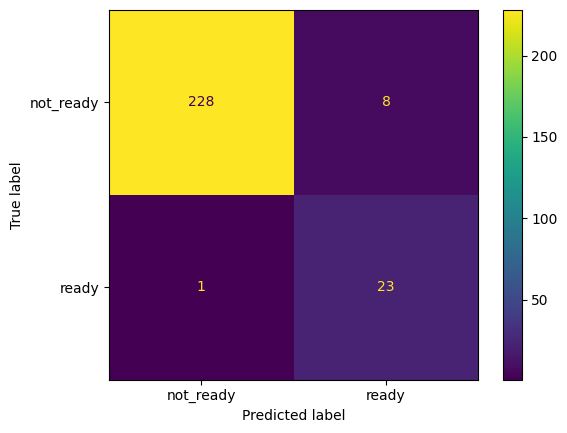

In [18]:
_ = ConfusionMatrixDisplay.from_estimator(rf, data_test, target_test)

Another measure to evalute the performance of the model is to plot a confusion matrix.
1. <b> True Positives (TP): </b> The samples that are `0:not ready` and were correctly predcited to be `0:not ready` [23]
2. <b> True Negatives (TN): </b> The samples that are `1:ready` and were correctly predcited to be `1:ready` [228]
3. <b> False Negative (FN): </b> The samples that are `0:not ready` and were incorrectly  predcited to be `1:ready` [8]
4. <b> False Positves (FN): </b> The samples that are `1:ready` and were incorrectly predcited to be not `0:not ready` [1]

In [19]:
precision = precision_score(target_test, target_predicted_test, pos_label="ready")
recall = recall_score(target_test, target_predicted_test, pos_label="ready")

print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")

Precision score: 0.742
Recall score: 0.958


> * The `Precision score` of <b> 0.742 </b> means that when the model predicts a sample is `ready` then it is accurate about <b>74.2%</b> of the time. 
> *The `Recall score` of <b> 0.958 </b> means that out of all the actual samples that are `ready`, the model correctly identifies <b>95.8%</b> them. Rest of the `ready` samples will be missed by the model. 

##### Using the helper function to record the scores for comparitive analysis. 

In [20]:
dummy = score_recorder("dummy", dummy_classifier, data_train, target_train, data_test, target_test)
random_forest = score_recorder("Random forest", rf, data_train, target_train, data_test, target_test)

c:\users\prateekwahi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
pd.concat([dummy, random_forest], axis = 0)

,Train_accuracy,Test_accuracy,Balanced_accuracy,Test_Precision,Test_Recall,Test_F1_score
dummy,0.916346,0.907692,0.500000,0.000000,0.000000,0.000000
Random forest,1.000000,0.965385,0.962218,0.741935,0.958333,0.836364


# Imbalance data set solutions. 

> There are two methods suggested in the literature to solve the problem of imbalanced class.
> 1. <b>Cost-sensitive</b> : Assigning high cost to missclassify the minority class. 

### 1. Testing Cost - sensitive method

> The cost sensitive method is applied using class_weight paramter in random forest classifier. Weight are calculated based on scikit learn doumentation. <br> Total samples / (Number of classes * number of samples in the class)

In [22]:
# calculating the weights as per scilearn documentation
ready = len(data)/(2 * target.value_counts()["ready"])
not_ready = len(data)/(2 * target.value_counts()["not_ready"])

In [23]:
# Randomforest classifier with eighted class
rf_weight = RandomForestClassifier(
    n_estimators= 100, 
    n_jobs=2, 
    random_state=random_state, 
    class_weight={"not_ready":not_ready, "ready":ready}
    # class_weight="balanced_subsample"
)

rf_weight.fit(data_train, target_train)

RandomForestClassifier(class_weight={'not_ready': 0.5466778805719091,
                                     'ready': 5.8558558558558556},
                       n_jobs=2, random_state=0)

In [24]:
weighted_class = score_recorder("RF_weighted_class", rf_weight, data_train, target_train, data_test, target_test)
pd.concat([dummy, random_forest, weighted_class])

,Train_accuracy,Test_accuracy,Balanced_accuracy,Test_Precision,Test_Recall,Test_F1_score
dummy,0.916346,0.907692,0.500000,0.000000,0.000000,0.000000
Random forest,1.000000,0.965385,0.962218,0.741935,0.958333,0.836364
RF_weighted_class,1.000000,0.980769,0.951977,0.880000,0.916667,0.897959


> * In the context of this study it is important to have a balanced Precision and Recall Score. 
> * <b>Precision Score</b> : Reducing `False Positives` by not labelling a sample `ready` when it is actually `not ready`. 
>> * <b><i>False Positives: </i></b> These occur when the model incorrectly predicts the positive class(`ready`). For example, when predicting whether a house is ready for MT or LT supply, a false positive would mean that the model predicts a house is ready when it’s actually not. The consequence might be that resources are wasted on a house that doesn’t need them
> * <b> Recall Score </b> : Reducing `false negatives` by recoginising all the samples that are `ready`. 
>> * <b><i>False Negatives: </i></b> These occur when the model incorrectly predicts the negative class (`not ready`). In the same example, a false negative would mean that the model predicts a house is not ready when it actually is. The consequence might be that a house that could benefit from MT or LT supply doesn’t receive it.

<Axes: >

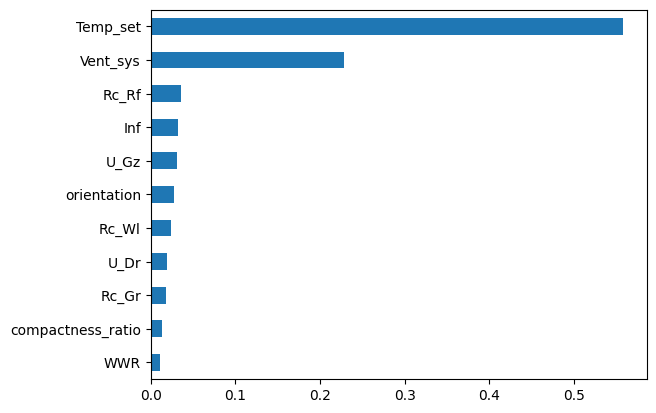

In [25]:
importances_weight = rf_weight.feature_importances_
feature_names_weight = rf_weight.feature_names_in_
pd.Series(importances_weight, feature_names_weight).sort_values(ascending=True).plot.barh()